In [19]:
import numpy as np

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib

from src import sinkhorn
from src import multigrid

from utils.metrics import *
from visualisation.transport_plan_visualisation import *
from dataset_generators.empirical_distributions import *

### The multigrid approach
---

Let us show the idea on the generated data

In [5]:
n = 128

n_x = [100, 100]
a_x = np.array([0.01, 0.01])

x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)

C = np.array(cdist(x_i, x_f))

n = x_i.shape[0]

a, b = np.ones((n,)) / n, np.ones((n,)) / n 

In [7]:
x_i_agg, a_agg, labels_i = multigrid.aggregate_points(x_i, weights=a, n_clusters=16)
x_f_agg, b_agg, labels_f = multigrid.aggregate_points(x_f, weights=b, n_clusters=16)

inverted_labels_i = multigrid.get_inverted_labels(labels_i)
inverted_labels_f = multigrid.get_inverted_labels(labels_f)

C_agg = cdist(x_i_agg, x_f_agg)

(-0.0495, 1.0395, -0.0495, 1.0395)

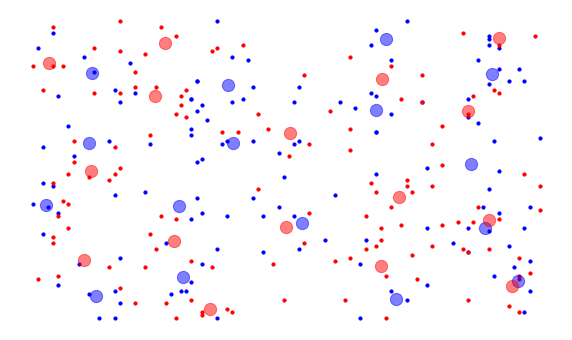

In [8]:
plt.figure(figsize = (10, 6))

#initial points
plt.scatter(x_i[:, 0], x_i[:, 1], color = 'blue', s = 10)
plt.scatter(x_f[:, 0], x_f[:, 1], color = 'red', s = 10)

#aggregated points
plt.scatter(x_i_agg[:, 0], x_i_agg[:, 1], s = 150, color = 'blue', alpha = 0.5)
plt.scatter(x_f_agg[:, 0], x_f_agg[:, 1], s = 150, color = 'red', alpha = 0.5)

plt.axis('off')

The small points are the points from the initial data. And the fat one are obtained via
`Agglomerative clustering`. 

Below is the assigment for the coarsened grid.

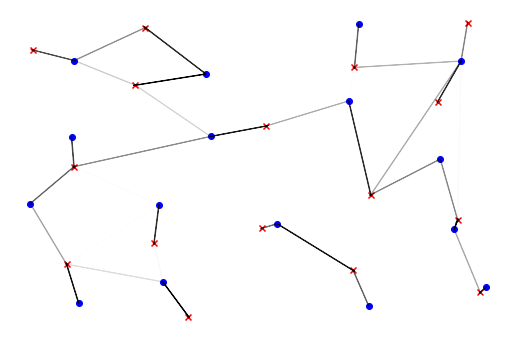

In [9]:
G_coarse = sinkhorn.sinkhorn_knopp(C_agg, reg = 1e-2, a = a_agg, b = b_agg, make_sparse=False)
plot_transportation_2d(x_i_agg, x_f_agg, G_coarse)

Then for the given clusters the refinement is performed.

### Performance measurements
---

We are generating considerable amount of points to check the implementation on it in order to benefit from `divide & conquer` approach. 

In [15]:
import importlib
importlib.reload(multigrid)

<module 'src.multigrid' from '/home/blackadder/NLA/optimal_transport_problem/src/multigrid.py'>

In [10]:
#generate the data
n = 4000

n_x = [100, 100]
a_x = np.array([0.01, 0.01])

x_i = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)
x_f = generate_on_square_grid(num_points = n, n_x = n_x, a_x = a_x)

C = np.array(cdist(x_i, x_f))

n = x_i.shape[0]

a, b = np.ones((n,)) / n, np.ones((n,)) / n 

First of all, we are going to plot the dependence of the cost on the size of the multigrid. 

In [16]:
n_clusters = 2 ** np.arange(3, 11)

costs = []

for n in n_clusters:
    G_multigrid = multigrid.sinkhorn_multigrid(C, x_i, x_f, reg_coarse=1e-2, reg_fine=1e-2, a = a, b = b, n_clusters_a=n, n_clusters_b=n)
    costs.append(np.sum(G_multigrid * C))

In [17]:
G_full = sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b)
cost_full = np.sum(G_full * C)

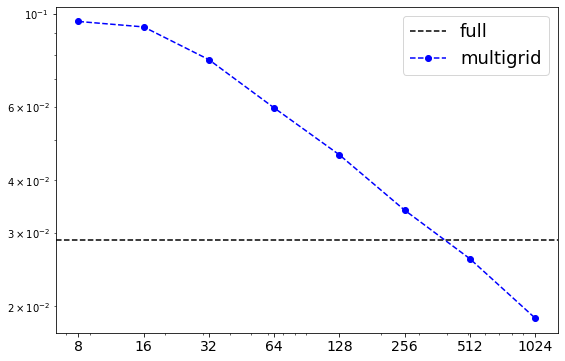

In [44]:
fig, ax = plt.subplots(figsize = (9, 6))

ax.axhline(y = cost_full, linestyle = '--', color = 'k', label = "full")
ax.loglog(n_clusters, costs, "o--", color = "blue", label = 'multigrid')

plt.xticks(n_clusters, fontsize = 14)

ax.legend(fontsize = 18)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

One can observe, that the quality becomes better with the increase of number of clusters. 
And for large number of clusters, approaching the size of the whole matrix it can be even slightly better. It is probablty due to the
fact the assigment is more sharp. 

Now we are proceeding to the time measurements. 

In [47]:
n_clusters = 2 ** np.arange(3, 11)

tm, tm_err = [], []

for n in n_clusters:
    t = %timeit -o multigrid.sinkhorn_multigrid(C, x_i, x_f, reg_coarse=1e-2, reg_fine=1e-2, a = a, b = b, n_clusters_a=n, n_clusters_b=n)
    tm.append(t.average)
    tm_err.append(t.stdev)

1.77 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.55 s ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.15 s ± 471 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.08 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.11 s ± 9.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.16 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.28 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.39 s ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
tm_full = %timeit -o sinkhorn.sinkhorn_knopp(C, reg = 1e-2, a = a, b = b, make_sparse=False)

26.8 s ± 2.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


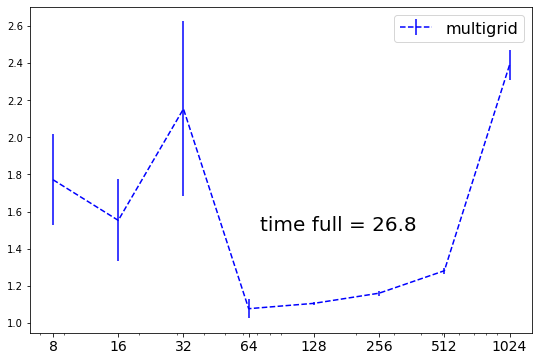

In [53]:
plt.figure(figsize = (9, 6))

plt.text(x = 72, y = 1.5, s = f"time full = {tm_full.average:.1f}", fontsize = 20)
plt.errorbar(n_clusters, tm, yerr = tm_err, fmt = "--", color = "blue", label = "multigrid")

plt.xscale("log")

plt.xticks(n_clusters, fontsize = 14)

plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.legend(fontsize = 16)

plt.savefig("timing_plots/multigrid_performance.png")

To conclude, the `multigrid` approach leads to considerable gain in performance `10-20x` times, in comparison 
to the *Sinkhorn* on the full matrix. The quality loss for the optimal in terms of performance data is not very big, hence, it 
can be a reasonable approach, to sacrifice a bit of quality in order to achieve noticeable speed-up. 